# LBM tutorial

## hello world 

 - First we will assume that there is a current version of a sailfish in current directory.
 
         !git clone https://github.com/sailfish-team/sailfish

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys,os
sys.path.append('./sailfish/')
if not (os.path.isdir('data') or os.path.islink('data')):
    os.mkdir('data')

In [32]:
!pwd

/home/marcin/NB/LBM_tutorial


In [33]:
%%writefile ex1.py
import numpy as np
from sailfish.subdomain import Subdomain2D
from sailfish.node_type import NTFullBBWall, NTEquilibriumVelocity
from sailfish.controller import LBSimulationController
from sailfish.lb_single import LBFluidSim

class MyBlock(Subdomain2D):
    max_v = 0.1

    def boundary_conditions(self, hx, hy):
        wall_map = ( (hx == self.gx-1) | (hx == 0) | (hy == 0) )
        self.set_node( (hy == self.gy-1) & (hx>0) & (hx<self.gx-1) , NTEquilibriumVelocity((self.max_v, 0.0)) )
        self.set_node(wall_map, NTFullBBWall)
        
    def initial_conditions(self, sim, hx, hy):
        sim.rho[:] = 1.0

class MySim(LBFluidSim):
    subdomain = MyBlock

LBSimulationController(MySim).run()

Overwriting ex1.py


In [34]:
%%sh
export PYTHONPATH=$PWD/sailfish/
python ex1.py --max_iters=100 --lat_nx=32 --lat_ny=32

[  1873  INFO Master/stratus] Machine master starting with PID 29258 at 2015-02-18 12:15:51 UTC
[  1902  INFO Master/stratus] Sailfish version: 9dd8b711d44c9e11614f7b760f32bdbbfa340064
[  1903  INFO Master/stratus] Handling subdomains: [0]
[  1903  INFO Master/stratus] Subdomain -> GPU map: {0: 0}
[  1903  INFO Master/stratus] Selected backend: cuda
[  1979  INFO Subdomain/0] Initializing subdomain.
[  1980  INFO Subdomain/0] Required memory: 
[  1980  INFO Subdomain/0] . distributions: 0 MiB
[  1980  INFO Subdomain/0] . fields: 0 MiB
[  2898  INFO Subdomain/0] Starting simulation.
[  2913  INFO Subdomain/0] Simulation completed after 100 iterations.


In [35]:
%%sh
export PYTHONPATH=$PWD/sailfish/
python ex1.py --max_iters=1000 --every=1000 \
 --lat_nx=32 --lat_ny=48 \
 --visc=0.1\
 --output=data/ex1 --output_format=npy

[  1813  INFO Master/stratus] Machine master starting with PID 29515 at 2015-02-18 12:15:58 UTC
[  1830  INFO Master/stratus] Sailfish version: 9dd8b711d44c9e11614f7b760f32bdbbfa340064
[  1830  INFO Master/stratus] Handling subdomains: [0]
[  1830  INFO Master/stratus] Subdomain -> GPU map: {0: 0}
[  1830  INFO Master/stratus] Selected backend: cuda
[  1901  INFO Subdomain/0] Initializing subdomain.
[  1901  INFO Subdomain/0] Required memory: 
[  1901  INFO Subdomain/0] . distributions: 0 MiB
[  1901  INFO Subdomain/0] . fields: 0 MiB
[  4279  INFO Subdomain/0] Starting simulation.
[  4366  INFO Subdomain/0] Simulation completed after 1000 iterations.


In [36]:
!ls data/ex1* -rtla

-rw-r--r-- 1 marcin marcin   586 Feb 18 13:15 data/ex1.subdomains
-rw-r--r-- 1 marcin marcin   493 Feb 18 13:16 data/ex1.0.0000.npz
-rw-r--r-- 1 marcin marcin 14781 Feb 18 13:16 data/ex1.0.1000.npz


In [37]:
data = np.load("data/ex1.0.1000.npz")
data.files

['rho', 'v']

In [38]:
data['v'][0].shape

(48, 32)

In [39]:
vx,vy = data['v']
vy.shape

(48, 32)

In [40]:
ny,nx = vx.shape

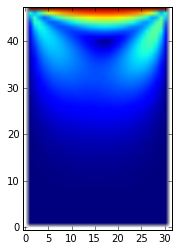

In [41]:
plt.imshow(np.sqrt(vx**2+vy**2),origin='top')

In [42]:
Y,X = np.mgrid[0:ny,0:nx]

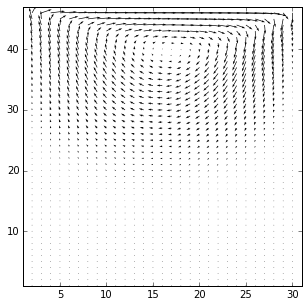

In [43]:
plt.figure(figsize=(5,5))
plt.xlim(1,nx-1)
plt.ylim(1,ny-1)
plt.quiver(X,Y,vx,vy)

In [44]:
vx.shape,X.shape

((48, 32), (48, 32))

<matplotlib.contour.QuadContourSet instance at 0x7f8c66594680>

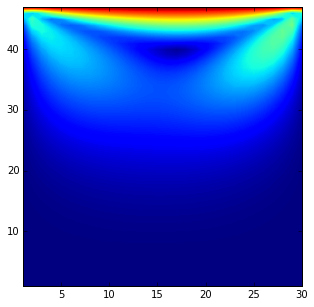

In [45]:
plt.figure(figsize=(5,ny/nx*5))
plt.xlim(1,nx-2)
plt.ylim(1,ny-1)
plt.contourf(X,Y,np.sqrt(vy**2+vx**2),256)

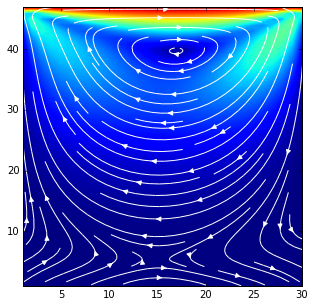

In [46]:
plt.figure(figsize=(5,ny/nx*5))
plt.xlim(1,nx-2)
plt.ylim(1,ny-1)
plt.contourf(X,Y,np.sqrt(vy**2+vx**2),256)
plt.streamplot(X,Y,vx,vy,color='white')


In [47]:
np.mgrid[0:4,0:4][0]

array([[0, 0, 0, 0],
       [1, 1, 1, 1],
       [2, 2, 2, 2],
       [3, 3, 3, 3]])

In [48]:
x = np.linspace(0,3,4)
X,Y = np.meshgrid(x,x)
X

array([[ 0.,  1.,  2.,  3.],
       [ 0.,  1.,  2.,  3.],
       [ 0.,  1.,  2.,  3.],
       [ 0.,  1.,  2.,  3.]])

In [49]:
%%writefile ex2.py
import numpy as np
from sailfish.subdomain import Subdomain2D
from sailfish.node_type import NTFullBBWall, NTEquilibriumVelocity
from sailfish.controller import LBSimulationController
from sailfish.lb_single import LBFluidSim

class MyBlock(Subdomain2D):
    max_v = 0.1

    def boundary_conditions(self, hx, hy):
        wall_map = ( (hx == self.gx-1) | (hx == 0) | (hy == 0) )
        self.set_node( (hy == self.gy-1) & (hx>0) & (hx<self.gx-1) , NTEquilibriumVelocity((self.max_v, 0.0)) )
        self.set_node(wall_map, NTFullBBWall)
        np.savez("data/hx.npz",hx=hx,hy=hy)
    def initial_conditions(self, sim, hx, hy):
        sim.rho[:] = 1.0
        
class MySim(LBFluidSim):
    subdomain = MyBlock

LBSimulationController(MySim).run()

Overwriting ex2.py


In [50]:
%%sh
export PYTHONPATH=$PWD/sailfish/
python ex2.py --max_iters=100 --lat_nx=32 --lat_ny=32

[  1842  INFO Master/stratus] Machine master starting with PID 30569 at 2015-02-18 12:16:26 UTC
[  1870  INFO Master/stratus] Sailfish version: 9dd8b711d44c9e11614f7b760f32bdbbfa340064
[  1870  INFO Master/stratus] Handling subdomains: [0]
[  1870  INFO Master/stratus] Subdomain -> GPU map: {0: 0}
[  1870  INFO Master/stratus] Selected backend: cuda
[  1945  INFO Subdomain/0] Initializing subdomain.
[  1945  INFO Subdomain/0] Required memory: 
[  1945  INFO Subdomain/0] . distributions: 0 MiB
[  1945  INFO Subdomain/0] . fields: 0 MiB
[  2860  INFO Subdomain/0] Starting simulation.
[  2869  INFO Subdomain/0] Simulation completed after 100 iterations.


In [51]:
!ls -lta hx*

-rw-r--r-- 1 marcin marcin 18854 Feb 18 08:58 hx.npz


In [52]:
data = np.load("data/hx.npz")
hx = data['hx']
hy = data['hy']

In [53]:
hx

array([[-1,  0,  1, ..., 30, 31, 32],
       [-1,  0,  1, ..., 30, 31, 32],
       [-1,  0,  1, ..., 30, 31, 32],
       ..., 
       [-1,  0,  1, ..., 30, 31, 32],
       [-1,  0,  1, ..., 30, 31, 32],
       [-1,  0,  1, ..., 30, 31, 32]])

In [54]:
(hx>0)

array([[False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       ..., 
       [False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True]], dtype=bool)

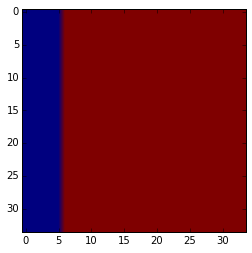

In [55]:
plt.imshow(hx>4)

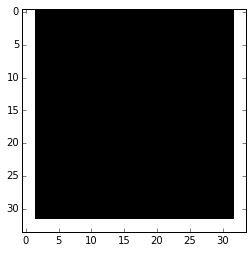

In [56]:
plt.imshow( (hy>30)|(hx<1) | (hx>30),interpolation='nearest',cmap='gray') 

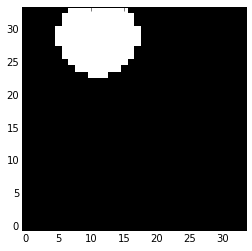

In [57]:
plt.imshow( (hx-10)**2+(hy-28)**2<6.2**2,interpolation='nearest',cmap='gray',origin='top') 

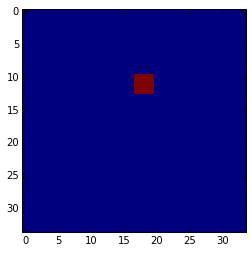

In [58]:
x0,y0,a = 15,8,4
plt.imshow( (hx>x0) & (hx<x0+a) & (hy>y0) & (hy<y0+a),interpolation='nearest') 

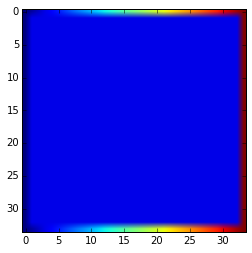

In [59]:
hx[1:-1,1:-1] = 2
plt.imshow(hx)

In [60]:
%%writefile ex3.py
import numpy as np
from sailfish.subdomain import Subdomain2D
from sailfish.node_type import NTFullBBWall, NTEquilibriumVelocity
from sailfish.controller import LBSimulationController
from sailfish.lb_single import LBFluidSim

class MyBlock(Subdomain2D):

    def boundary_conditions(self, hx, hy):
        wall_map = ( (hx == self.gx-1) | (hx == 0) | (hy == 0) | (hy == self.gy-1) )
        self.set_node(wall_map, NTFullBBWall)
        x0,y0,a = 15,8,4
        square_map = (hx>x0) & (hx<x0+a) & (hy>y0) & (hy<y0+a)
        self.set_node( square_map , NTEquilibriumVelocity(( 0.1, 0.18)) )
        x0,y0,a = 15+6,8+6,4
        square_map = (hx>x0) & (hx<x0+a) & (hy>y0) & (hy<y0+a)
        self.set_node(square_map, NTFullBBWall)
        
    def initial_conditions(self, sim, hx, hy):
        sim.rho[:] = 1.0
        #sim.vx[hy == self.gy-1] = self.max_v


class MySim(LBFluidSim):
    subdomain = MyBlock

LBSimulationController(MySim).run()

Writing ex3.py


In [61]:
%%sh
export PYTHONPATH=$PWD/sailfish/
python ex3.py --max_iters=1000 --every=1000 \
 --lat_nx=32 --lat_ny=32 \
 --visc=0.1002 \
 --output=data/ex3 --output_format=npy

[  1887  INFO Master/stratus] Machine master starting with PID 32220 at 2015-02-18 12:17:16 UTC
[  1914  INFO Master/stratus] Sailfish version: 9dd8b711d44c9e11614f7b760f32bdbbfa340064
[  1915  INFO Master/stratus] Handling subdomains: [0]
[  1915  INFO Master/stratus] Subdomain -> GPU map: {0: 0}
[  1915  INFO Master/stratus] Selected backend: cuda
[  1996  INFO Subdomain/0] Initializing subdomain.
[  1996  INFO Subdomain/0] Required memory: 
[  1996  INFO Subdomain/0] . distributions: 0 MiB
[  1996  INFO Subdomain/0] . fields: 0 MiB
[  4387  INFO Subdomain/0] Starting simulation.
[  4495  INFO Subdomain/0] Simulation completed after 1000 iterations.


In [64]:
!ls -lrta data/ex3*


-rw-r--r-- 1 marcin marcin   586 Feb 18 13:17 data/ex3.subdomains
-rw-r--r-- 1 marcin marcin   495 Feb 18 13:17 data/ex3.0.0000.npz
-rw-r--r-- 1 marcin marcin 10014 Feb 18 13:17 data/ex3.0.1000.npz


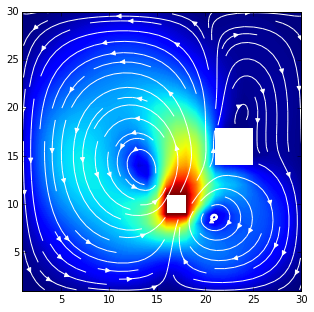

In [65]:
data = np.load("data/ex3.0.1000.npz")
vx,vy = data['v']
ny,nx = vx.shape
Y,X = np.mgrid[0:ny,0:nx]
plt.figure(figsize=(5,ny/nx*5))
plt.xlim(1,nx-2)
plt.ylim(1,ny-2)
plt.contourf(X,Y,np.sqrt(vy**2+vx**2),256)
plt.streamplot(X,Y,vx,vy,color='white')
